# Accessing and Processing the Optical Absorption and Attenuation (OPTAA) Data from the Coastal Surface Piercing Profiler (CSPP)

In [1]:
%matplotlib inline

# load the different libraries and modules needed for the analysis
import csv
import io
import numpy as np
import os
import pandas as pd
import re
import xarray as xr

from ooi_data_explorations.common import m2m_request, m2m_collect, get_deployment_dates
from pyseas.data.opt_functions import opt_internal_temp, opt_external_temp

import warnings
warnings.filterwarnings('ignore')

from matplotlib import pyplot as plt
plt.style.use('seaborn-white')

For this example, we'll look at the data from Deployment 19 of the Oregon Shelf Coastal Surface-Piercing Profiler (CSPP).

In [2]:
# Setup needed parameters for the request
site = 'CE02SHSP'           # OOI Net site designator
node = 'SP001'              # OOI Net node designator
sensor = '04-OPTAAJ000'     # OOI Net sensor designator
method = 'recovered_cspp'   # OOI Net data delivery method
stream = 'optaa_dj_cspp_instrument_recovered'  # OOI Net stream name
start, stop = get_deployment_dates(site, node, sensor, 19)
tag = '.*deployment0019.*OPTAA.*\\.nc$'  # limit request to OPTAA NetCDF files from Deployment 19

# request the data from the OOI M2M API ...
r = m2m_request(site, node, sensor, method, stream, start, stop)
data = m2m_collect(r, tag)

Requesting:
	refdes: CE02SHSP-SP001-04-OPTAAJ000
	method: recovered_cspp
	stream: optaa_dj_cspp_instrument_recovered
	from 2021-04-06T16:51:00.000Z to 2021-04-29T19:58:00.000Z
Waiting for OOINet to process and prepare data request, this may take up to 20 minutes.
Waiting: 100%|███████████████████████████████████████████████████████████████████████████████████████| 400/400 [02:30<00:00,  2.65it/s]


In [3]:
# Do some basic clean-up of the data prior to further work

# drop some of the variables:
#   internal_timestamp == time, redundant so can remove
#   profiler_timestamp == internal_timestamp == time, redundant so can remove
#   suspect_timestamp = not used, value uncertain
#   pressure_counts = no OOI OPTAA's have a pressure sensor, all 0's so can remove
data = data.drop(['internal_timestamp', 'profiler_timestamp', 'suspect_timestamp', 'pressure_counts'])

# rename some of the variables so it is bit clearer where they came from
#   salinity => ctd_salinity, interpolated in from co-located CTD
#   temperature => ctd_temperature, interpolated in from co-located CTD
#   int_ctd_pressure => ctd_pressure, interpolated in from co-located CTD
rename = {
    'temperature': 'ctd_temperature',
    'salinity': 'ctd_salinity',
    'int_ctd_pressure': 'ctd_pressure'
}
data = data.rename(rename)

# add the original variable name as an attribute, if renamed
for key, value in rename.items():
    data[value].attrs['ooinet_variable_name'] = key
    
data

<xarray.Dataset>
Dimensions:                  (time: 70378, wavelength: 83)
Coordinates:
  * wavelength               (wavelength) int32 0 1 2 3 4 5 ... 78 79 80 81 82
  * time                     (time) datetime64[ns] 2021-04-06T17:22:15.265000...
Data variables:
    external_temp_raw        (time) uint16 40662 40661 40660 ... 38972 38970
    c_signal_counts          (time, wavelength) uint16 630 743 869 ... 6703 5928
    deployment               (time) int32 19 19 19 19 19 19 ... 19 19 19 19 19
    a_signal_counts          (time, wavelength) uint16 900 1055 ... 9289 8183
    a_reference_counts       (time, wavelength) uint16 803 926 ... 8924 8275
    internal_temp_raw        (time) uint16 51227 51229 51217 ... 50526 50534
    c_reference_dark_counts  (time) uint16 467 466 467 467 ... 466 466 466 466
    num_wavelengths          (time) uint8 83 83 83 83 83 83 ... 83 83 83 83 83
    on_seconds               (time) float32 10.42 10.67 10.92 ... 504.6 504.9
    c_signal_dark_counts     (time) uint16 702 702 703 703 ... 703 702 702 702
    a_signal_dark_counts     (time) uint16 689 689 689 689 ... 714 714 715 715
    a_reference_dark_counts  (time) uint16 457 457 457 457 ... 457 457 457 457
    c_reference_counts       (time, wavelength) uint16 740 849 969 ... 9119 8456
    wavelength_a             (wavelength) float64 398.5 402.3 ... 731.0 734.3
    wavelength_c             (wavelength) float64 400.7 404.1 ... 732.7 736.6
    ctd_salinity             (time) float64 33.72 33.72 33.72 ... 30.21 30.21
    ctd_temperature          (time) float64 8.12 8.12 8.12 ... 10.96 10.95 10.95
    beam_attenuation         (time, wavelength) float64 0.3294 0.3343 ... 0.4059
    optical_absorption       (time, wavelength) float64 nan 0.06129 ... -0.0127
    ctd_pressure             (time) float64 76.28 76.23 76.18 ... 0.9978 0.993
    depth                    (time) float64 75.65 75.6 75.55 ... 0.9897 0.985
    lat                      (time) float64 44.64 44.64 44.64 ... 44.64 44.64
    lon                      (time) float64 -124.3 -124.3 ... -124.3 -124.3
Attributes:
    node:                               SP001
    comment:                            Data collected from the OOI M2M API a...
    publisher_email:                    
    sourceUrl:                          http://oceanobservatories.org/
    collection_method:                  recovered_cspp
    stream:                             optaa_dj_cspp_instrument_recovered
    featureType:                        timeSeries
    creator_email:                      
    publisher_name:                     Ocean Observatories Initiative
    date_modified:                      2022-04-27T17:27:16.765950
    keywords:                           
    cdm_data_type:                      Station
    references:                         More information can be found at http...
    Metadata_Conventions:               Unidata Dataset Discovery v1.0
    date_created:                       2022-04-27T17:27:16.765947
    id:                                 CE02SHSP-SP001-04-OPTAAJ000-recovered...
    requestUUID:                        03c6cbd7-d36b-4230-9eb7-a1c1c7177b1a
    contributor_role:                   
    summary:                            Dataset Generated by Stream Engine fr...
    keywords_vocabulary:                
    institution:                        Ocean Observatories Initiative
    naming_authority:                   org.oceanobservatories
    infoUrl:                            http://oceanobservatories.org/
    license:                            
    contributor_name:                   
    uuid:                               03c6cbd7-d36b-4230-9eb7-a1c1c7177b1a
    creator_name:                       Ocean Observatories Initiative
    title:                              Data produced by Stream Engine versio...
    sensor:                             04-OPTAAJ000
    standard_name_vocabulary:           NetCDF Climate and Forecast (CF) Meta...
    acknowledgement:               

The OOI OPTAA data sets do not include the data products from the intermediary optical absorption and beam attenuation processing steps, where:

- the data has been converted from the raw, but has not been corrected for the effects of temperature and salinity 
- the data has been has been corrected for the effects of temperature and salinity
- the optical absorption data has been corrected for effects of scattering

In order to create these intermediate data, we need to download the calibration data for the instrument from the OOI Asset Management records hosted on GitHub.

In [4]:
# Pull the calibration coefficients from the GitHub hosted Asset Management system.
from cgsn_processing.process.finding_calibrations import find_calibration
from cgsn_processing.process.proc_optaa import Calibrations

# load the instrument calibration data
coeff_file = 'optaa.cal_coeffs.json'
dev = Calibrations(coeff_file)  # initialize calibration class

# check for the source of calibration coeffs and load accordingly
if os.path.isfile(coeff_file):
    # we always want to use this file if it already exists
    dev.load_coeffs()
else:
    # load from the CI hosted CSV files
    csv_url = find_calibration('OPTAA', data.attrs['SerialNumber'][4:], 
                               data['time'][0].values.astype(float) / 10**9)
    if csv_url:
        tca_url = re.sub('.csv', '__CC_taarray.ext', csv_url)
        tcc_url = re.sub('.csv', '__CC_tcarray.ext', csv_url)
        dev.read_devurls(csv_url, tca_url, tcc_url)
        dev.save_coeffs()

# check the device file coefficients against the data file contents
if dev.coeffs['serial_number'] != int(data.attrs['SerialNumber'][4:]):
    raise Exception('Serial Number mismatch between ac-s data and the device file.')
if dev.coeffs['num_wavelengths'] != data['num_wavelengths'][0]:
    raise Exception('Number of wavelengths mismatch between ac-s data and the device file.')
    
dev.coeffs

{'temp_calibration': 19.5,
 'a_wavelengths': array([398.5, 402.3, 405.9, 409.4, 413. , 416.6, 420.6, 424.7, 428.8,
        432.9, 437. , 440.7, 445.5, 449.7, 454.5, 458.5, 462.7, 467.1,
        471.5, 476.6, 481.1, 485.5, 489.7, 494.1, 498.2, 502.4, 507.3,
        511.6, 516.5, 521. , 525.3, 529.2, 533.5, 537.7, 541.8, 546.1,
        550.5, 554.8, 559.3, 563.3, 567.1, 571.2, 575.4, 577.8, 581.5,
        585.2, 588.8, 592.8, 596.9, 600.9, 605.5, 609.7, 613.7, 618. ,
        622.5, 626.5, 630.5, 634.5, 639.2, 643.3, 647.6, 651.9, 656.2,
        660.3, 664.6, 669.1, 673.4, 677.5, 681.6, 685. , 689. , 692.9,
        696.8, 700.4, 704.2, 708.3, 711.8, 715.7, 719.7, 723.3, 726.5,
        731. , 734.3]),
 'a_offsets': array([ 0.492155,  0.566451,  0.625848,  0.67317 ,  0.711699,  0.747972,
         0.78336 ,  0.814832,  0.844638,  0.876427,  0.906457,  0.936035,
         0.965321,  0.994832,  1.024699,  1.054943,  1.085137,  1.113145,
         1.142361,  1.170271,  1.196782,  1.223392,  1.249

With those calibration coefficients in hand, the following functions can be used to recalculate the intermediate data products

In [5]:
# Recalculate the absorption and attenuation data products from the raw data to provide the 
# intermediate data products between the final absorption and beam_attenuation. These functions
# are available in the cgsn_processing package (some of the variable names are different, so 
# differences would need to be accounted for), and are reproduced here to provide better insight
# into the exact sequence of processing to go from raw OPTAA data to a final temperature, 
# salinity and scatter corrected data products.
from pyseas.data.opt_functions import opt_internal_temp, opt_external_temp
from pyseas.data.opt_functions import opt_pd_calc, opt_tempsal_corr

def apply_dev(optaa, coeffs):
    """
    Processes the raw data contained in the optaa dictionary and applies the 
    factory calibration coefficents contained in the coeffs dictionary to
    convert the data into initial science units.

    :param optaa: xarray dataset with the raw absorption and beam attenuation
        measurements.
    :param coeffs: Factory calibration coefficients in a dictionary structure

    :return optaa: xarray dataset with the raw absorption and beam attenuation
        measurements converted into particulate and beam attenuation values
        with the factory pure water calibration values subtracted.
    """
    # convert internal and external temperature sensors
    optaa['internal_temp'] = opt_internal_temp(optaa['internal_temp_raw'])
    optaa['external_temp'] = opt_external_temp(optaa['external_temp_raw'])

    # setup inputs
    a_ref = optaa['a_reference_counts']
    a_sig = optaa['a_signal_counts']
    c_ref = optaa['c_reference_counts']
    c_sig = optaa['c_signal_counts']
    npackets = a_ref.shape[0]

    # initialize the output arrays
    apd = a_ref * np.nan
    cpd = c_ref * np.nan
    
    # calculate the L1 OPTAA data products (uncorrected beam attenuation and absorbance) for particulate
    # and dissolved organic matter with pure water removed.
    for ii in range(npackets):
        # calculate the uncorrected optical absorption coefficient [m^-1]
        apd[ii, :], _ = opt_pd_calc(a_ref[ii, :], a_sig[ii, :], coeffs['a_offsets'],
                                    optaa['internal_temp'].values[ii], coeffs['temp_bins'],
                                    coeffs['ta_array'])
        # calculate the uncorrected optical attenuation coefficient [m^-1]
        cpd[ii, :], _ = opt_pd_calc(c_ref[ii, :], c_sig[ii, :], coeffs['c_offsets'],
                                    optaa['internal_temp'].values[ii], coeffs['temp_bins'],
                                    coeffs['tc_array'])

    # save the results back to the data set
    optaa['apd'] = apd
    optaa['cpd'] = cpd

    # return the optaa dictionary with the factory calibrations applied
    return optaa


def apply_tscorr(optaa, coeffs, temp=None, salinity=None):
    """
    Corrects the absorption and beam attenuation data for the absorption
    of seawater as a function of the seawater temperature and salinity (the
    calibration blanking offsets are determined using pure water.)
    
    If inputs temp or salinity are not supplied as calling arguments, then the 
    following default values are used.
        
        temp: temperature values recorded by the ac-s's external thermistor.
        salinity: 33.0 psu

    Otherwise, each of the arguments for temp and salinity should be either a 
    scalar, or a 1D array or a row or column vector with the same number of time
    points as 'a' and 'c'.

    :param optaa: xarray dataset with the temperature and salinity corrected
        absorbance data array that will be corrected for the effects of
        scattering.
    :param coeffs: Factory calibration coefficients in a dictionary structure
    :param temp: In-situ seawater temperature, ideally from a co-located CTD
    :param salinity: In-situ seawater salinity, ideally from a co-located CTD

    :return optaa: xarray dataset with the temperature and salinity corrected
        absorbance and attenuation data arrays added.
    """
    # setup the temperature and salinity arrays
    if temp is None:
        temp = optaa['external_temp'].values
    else: 
        if np.array(temp).size == 1:
            temp = np.ones_like(optaa['external_temp']) * temp
        else:
            temp = np.array(temp)
    
    if temp.size != optaa['time'].size:
        raise Exception("Mismatch: temperature array != number of OPTAA measurements")

    if salinity is None:
        salinity = np.ones_like(optaa['external_temp']) * 33.0
    else:
        if np.array(salinity).size == 1:
            salinity = np.ones_like(optaa['external_temp']) * salinity
        else:
            salinity = np.array(salinity)

    if salinity.size != optaa['time'].size:
        raise Exception("Mismatch: salinity array != number of OPTAA measurements")

    # setup and size the inputs
    apd = optaa['apd']
    cpd = optaa['cpd']
    npackets = apd.shape[0]
    wvlngth = ~np.isnan(apd[0, :].values)

    # initialize the output arrays
    apd_ts = apd * np.nan
    cpd_ts = cpd * np.nan

    # apply the temperature and salinity corrections
    for ii in range(npackets):
        apd_ts[ii, wvlngth] = opt_tempsal_corr('a', apd[ii, wvlngth], coeffs['a_wavelengths'],
                                               coeffs['temp_calibration'], temp[ii], salinity[ii])
        cpd_ts[ii, wvlngth] = opt_tempsal_corr('c', cpd[ii, wvlngth], coeffs['c_wavelengths'],
                                               coeffs['temp_calibration'], temp[ii], salinity[ii])
    
    # save the results
    optaa['apd_ts'] = apd_ts
    optaa['cpd_ts'] = cpd_ts
    return optaa


def apply_scatcorr(optaa, coeffs):
    """
    Correct the absorbance data for scattering using Method 1, with the
    wavelength closest to 715 nm used as the reference wavelength for the
    scattering correction.

    :param optaa: xarray dataset with the temperature and salinity corrected
        absorbance data array that will be corrected for the effects of
        scattering.
    :param coeffs: Factory calibration coefficients in a dictionary structure

    :return optaa: xarray dataset with the method 1 scatter corrected
        absorbance data array added.
    """
    # find the closest wavelength to 715 nm
    reference_wavelength = 715.0
    idx = np.argmin(np.abs(coeffs['a_wavelengths'] - reference_wavelength))

    # use that wavelength as our scatter correction wavelength
    apd_ts = optaa['apd_ts']
    apd_ts_s = apd_ts - apd_ts[:, idx]

    # save the results
    optaa['apd_ts_s'] = apd_ts_s
    return optaa


def estimate_chl_poc(optaa, coeffs):
    """
    Derive estimates of Chlorophyll-a and particulate organic carbon (POC)
    concentrations from the temperature, salinity and scatter corrected
    absorption and beam attenuation data.

    :param optaa: xarray dataset with the scatter corrected absorbance data.
    :param coeffs: Factory calibration coefficients in a dictionary structure

    :return optaa: xarray dataset with the estimates for chlorophyll and POC
        concentrations added.
    """
    # use the standard chlorophyll line height estimation with an extinction coefficient of 0.020.
    m676 = np.argmin(np.abs(coeffs['a_wavelengths'] - 676.0))
    m650 = np.argmin(np.abs(coeffs['a_wavelengths'] - 650.0))
    m715 = np.argmin(np.abs(coeffs['a_wavelengths'] - 715.0))
    apg = optaa['apd_ts_s']
    aphi = apg[:, m676] - 39/65 * apg[:, m650] - 26/65 * apg[:, m715]
    optaa['estimated_chlorophyll'] = aphi / 0.020

    # estimate the POC concentration from the attenuation at 660 nm
    m660 = np.argmin(np.abs(coeffs['c_wavelengths'] - 660.0))
    cpg = optaa['cpd_ts']
    optaa['estimated_poc'] = cpg[:, m660] * 380

    return optaa

In [34]:
# apply the device file and the temperature, salinity and scatter corrections
data = apply_dev(data, dev.coeffs)
data = apply_tscorr(data, dev.coeffs, data.ctd_temperature, data.ctd_salinity)
data = apply_scatcorr(data, dev.coeffs)

# estimate chlorophyll-a and POC concentrations from the absorption and attenuation data, respectively.
data = estimate_chl_poc(data, dev.coeffs)

The data needs some slight re-organization so it can be used across deployments and sites. First, it needs to be split into profiles. For each profile, per the vendor recommendation, we want to drop the first 60 seconds worth of data (filter wheel spin-up and lamp warm-up), then we want to bin the data into 25 cm depth bins using median averages. Finally, once the profiles are identified and depth averaged, and the dataset is recombined, we need to make sure we have a consistent number of wavelengths (each OPTAA will have a different number of wavelengths), so we can combine multiple deployments together.

In [41]:
def process_profile(profile):
    """
    """
    # drop the first 60 seconds worth of data
    profile = profile.where(profile.on_seconds > 60, drop=True)
    
    # bin the data into 25 cm depth bins (center bins by using a 1/2 bin size offset)
    bins = profile.groupby_bins('depth', np.arange(0.125, 75.125, 0.25))    
    
    # compute the median averages of the binned data. since we can't preserve 
    # the data set the way we want, we need to process each bin separately
    binned = []
    for grp in bins:
        avg = grp[1].median('time', keepdims=True, keep_attrs=True)            # median averages
        avg = avg.assign_coords({'time': np.atleast_1d(grp[1].time.mean().values)})  # add time back
        avg['wavelength_a'] = avg.wavelength_a.transpose()                     # swap dimension order 
        avg['wavelength_c'] = avg.wavelength_c.transpose()                     # swap dimension order 
        avg['depth'] = avg['depth'] * 0 + grp[0].mid                           # set depth to bin midpoint
        binned.append(avg)                                                     # append to the list

    # recombine the binned data back into a single dataset
    profile = xr.concat(binned, 'time')
    profile = profile.sortby('time')

    # create an xarray dataset of the 2D variables, padding the number of wavelengths to a consistent 
    # length of 100 using fill values.
    wavelength_number = np.arange(100).astype(np.int32)  # used as a dimensional variable
    num_wavelengths = profile.num_wavelengths.values[0].astype(np.int32)
    pad = 100 - num_wavelengths
    fill_nan = np.tile(np.ones(pad) * np.nan, (len(profile.time), 1))
    fill_int = np.tile(np.ones(pad) * -9999999, (len(profile.time), 1))

    wavelength_a = np.concatenate([profile.wavelength_a.values, fill_nan], axis=1)
    wavelength_c = np.concatenate([profile.wavelength_c.values, fill_nan], axis=1)

    ac = xr.Dataset({
        'wavelength_a': (['time', 'wavelength'], wavelength_a),
        'a_signal_counts': (['time', 'wavelength'], np.concatenate([profile.a_signal_counts.astype(np.int32), 
                                                                    fill_int], axis=1)),
        'a_reference_counts': (['time', 'wavelength'], np.concatenate([profile.a_reference_counts.astype(np.int32),
                                                                       fill_int], axis=1)),
        'optical_absorption': (['time', 'wavelength'], np.concatenate([profile.optical_absorption, fill_nan], 
                                                                       axis=1)),
        'apd': (['time', 'wavelength'], np.concatenate([profile.apd, fill_nan], axis=1)),
        'apd_ts': (['time', 'wavelength'], np.concatenate([profile.apd_ts, fill_nan], axis=1)),
        'apd_ts_s': (['time', 'wavelength'], np.concatenate([profile.apd_ts_s, fill_nan], axis=1)),
        'wavelength_c': (['time', 'wavelength'], wavelength_c),
        'c_signal_counts': (['time', 'wavelength'], np.concatenate([profile.c_signal_counts.astype(np.int32),
                                                                    fill_int], axis=1)),
        'c_reference_counts': (['time', 'wavelength'], np.concatenate([profile.c_reference_counts.astype(np.int32),
                                                                       fill_int], axis=1)),
        'beam_attenuation': (['time', 'wavelength'], np.concatenate([profile.beam_attenuation, fill_nan], 
                                                                     axis=1)),
        'cpd': (['time', 'wavelength'], np.concatenate([profile.cpd, fill_nan], axis=1)),
        'cpd_ts': (['time', 'wavelength'], np.concatenate([profile.cpd_ts, fill_nan], axis=1)),
    }, coords={'time': (['time'], profile.time.values), 'wavelength': wavelength_number})    
    
    # drop the original 2D variables from the profile data set
    drop = profile.drop(['wavelength_a', 'a_signal_counts', 'a_reference_counts', 'optical_absorption',
                         'wavelength_c', 'c_signal_counts', 'c_reference_counts', 'beam_attenuation',
                         'apd', 'apd_ts', 'apd_ts_s', 'cpd', 'cpd_ts'])

    # reset the data type for the 'a' and 'c' signal and reference dark values, and the other raw parameters
    int_arrays = ['wavelength', 'a_signal_dark_counts', 'a_reference_dark_counts', 'c_signal_dark_counts', 
                  'c_reference_dark_counts', 'internal_temp_raw', 'external_temp_raw', 
                  'num_wavelengths', 'deployment']
    for k in drop.variables:
        if k in int_arrays:
            drop[k] = drop[k].astype(np.int32)

    # recombine the two datasets
    optaa = xr.merge([drop, ac])

    # reset the attributes, which the merging drops
    optaa.attrs = profile.attrs
    for v in optaa.variables:
        optaa[v].attrs = profile[v].attrs
        
    return optaa

In [42]:
# split the data into profiles -- assume at least 120 seconds between profiles
dt = data.where(data['time'].diff('time') > np.timedelta64(120, 's'), drop=True).get_index('time')

# process each profile, adding the results to a list of profiles
profiles = []
for i, d in enumerate(dt):
    if i == 0:
        profile = data.where(data['time'] < d, drop=True)
    else:
        profile = data.where((data['time'] >= dt[i-1]) & (data['time'] < d), drop=True)

    # add the profile to the list
    profiles.append(process_profile(profile))

# grab the last profile and append it to the list
profile = data.where(data['time'] >= dt[-1], drop=True)
profiles.append(process_profile(profile))

profiles[5]

<xarray.Dataset>
Dimensions:                  (time: 278, wavelength: 100)
Coordinates:
  * wavelength               (wavelength) int64 0 1 2 3 4 5 ... 95 96 97 98 99
  * time                     (time) datetime64[ns] 2021-04-06T21:07:12.323428...
Data variables:
    external_temp_raw        (time) int32 40668 40668 40669 ... 40115 40116
    deployment               (time) int32 19 19 19 19 19 19 ... 19 19 19 19 19
    internal_temp_raw        (time) int32 51231 51224 51224 ... 50970 50968
    c_reference_dark_counts  (time) int32 467 467 467 466 ... 469 467 468 467
    num_wavelengths          (time) int32 83 83 83 83 83 83 ... 83 83 83 83 83
    on_seconds               (time) float64 60.96 62.59 63.84 ... 350.8 353.7
    c_signal_dark_counts     (time) int32 703 703 704 703 ... 705 704 704 704
    a_signal_dark_counts     (time) int32 689 689 689 689 ... 696 696 697 698
    a_reference_dark_counts  (time) int32 456 456 456 456 ... 456 456 457 457
    ctd_salinity             (time) float64 33.73 33.73 33.73 ... 31.35 31.36
    ctd_temperature          (time) float64 8.112 8.112 8.112 ... 9.026 9.017
    ctd_pressure             (time) float64 74.08 73.87 73.61 ... 4.509 4.343
    depth                    (time) float64 73.5 73.25 73.0 ... 4.75 4.5 4.25
    lat                      (time) float64 44.64 44.64 44.64 ... 44.64 44.64
    lon                      (time) float64 -124.3 -124.3 ... -124.3 -124.3
    internal_temp            (time) float64 8.066 8.088 8.088 ... 8.86 8.866
    external_temp            (time) float64 7.959 7.959 7.957 ... 8.853 8.851
    estimated_chlorophyll    (time) float64 -0.1158 -0.09946 ... 3.238 3.182
    estimated_poc            (time) float64 88.79 88.68 90.4 ... 247.3 244.6
    wavelength_a             (time, wavelength) float64 398.5 402.3 ... nan nan
    a_signal_counts          (time, wavelength) float64 895.0 ... -1e+07
    a_reference_counts       (time, wavelength) float64 795.0 918.0 ... -1e+07
    optical_absorption       (time, wavelength) float64 nan 0.04631 ... nan nan
    apd                      (time, wavelength) float64 0.04991 0.04632 ... nan
    apd_ts                   (time, wavelength) float64 nan 0.04631 ... nan nan
    apd_ts_s                 (time, wavelength) float64 nan 0.04828 ... nan nan
    wavelength_c             (time, wavelength) float64 400.7 404.1 ... nan nan
    c_signal_counts          (time, wavelength) float64 632.0 746.0 ... -1e+07
    c_reference_counts       (time, wavelength) float64 728.0 839.0 ... -1e+07
    beam_attenuation         (time, wavelength) float64 0.2544 0.2673 ... nan
    cpd                      (time, wavelength) float64 0.2528 0.2656 ... nan
    cpd_ts                   (time, wavelength) float64 0.2544 0.2673 ... nan
Attributes:
    node:                               SP001
    comment:                            Data collected from the OOI M2M API a...
    publisher_email:                    
    sourceUrl:                          http://oceanobservatories.org/
    collection_method:                  recovered_cspp
    stream:                             optaa_dj_cspp_instrument_recovered
    featureType:                        timeSeries
    creator_email:                      
    publisher_name:                     Ocean Observatories Initiative
    date_modified:                      2022-04-27T17:27:16.765950
    keywords:                           
    cdm_data_type:                      Station
    references:                         More information can be found at http...
    Metadata_Conventions:               Unidata Dataset Discovery v1.0
    date_created:                       2022-04-27T17:27:16.765947
    id:                                 CE02SHSP-SP001-04-OPTAAJ000-recovered...
    requestUUID:                        03c6cbd7-d36b-4230-9eb7-a1c1c7177b1a
    contributor_role:                   
    summary:                            Dataset Generated by Stream Engine fr...
    keywords_vocabulary:              

## Save the data for future work

At this point the optaa record is at a point where it can be saved locally or used in further work looking across deployments or between sites.

Some of the work one might want to do is a review of the data by comparing the instrument temperature records versus the co-located CTD data, plot estimated chlorophyll and POC concentrations, or review the shape and magnitude of the aborption and attenuation spectra.

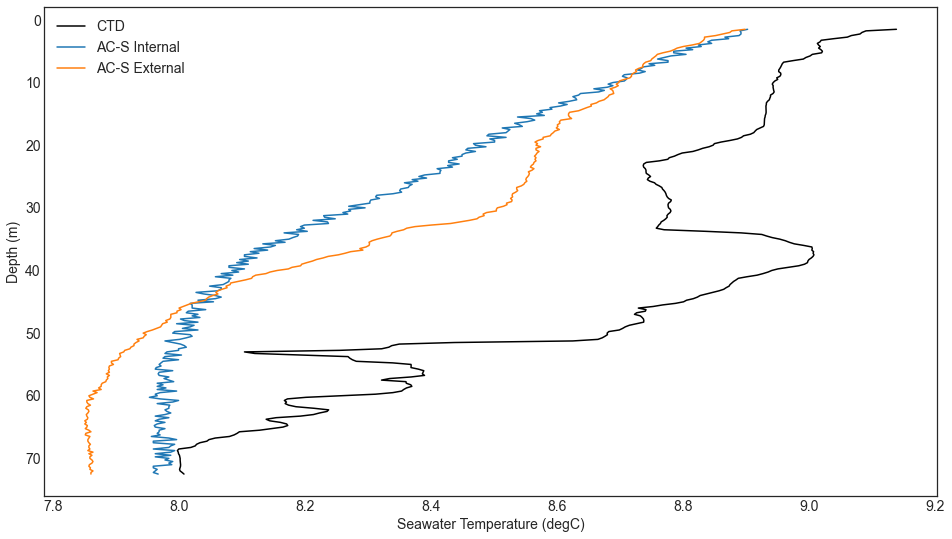

In [38]:
%matplotlib inline

# Plot the instrument and co-located CTD temperature records for profile 10
profile = profiles[9]
plt.rcParams.update({'font.size': 14})
fig = plt.figure(figsize=(16,9))
plt.plot(profile['ctd_temperature'], profile['depth'], '-k', label='CTD')
plt.plot(profile['internal_temp'], profile['depth'], label='AC-S Internal')
plt.plot(profile['external_temp'], profile['depth'], label='AC-S External')
plt.gca().invert_yaxis()
plt.xlabel('Seawater Temperature (degC)')
plt.ylabel('Depth (m)')
plt.legend()

The CTD seawater temperature and the instrument internal temperature are inputs to the functions used to calculate the optical absorption and beam attenuation. The data from the external temperature sensor on the AC-S is not used in the processing. It is not as accurate as the CTD temperature sensor and it has a slower response rate, so it doesn't accurately represent conditions in the water column. There is still some value to it, just take it with a grain of salt.

That being said, there are a couple of things to note. The internal temperature and the external water temperature (from the CTD) should be close to each other near the start of the profile, diverging as the profiler rises through the water column. Also, the external temperature sensor, with some offset due to differences in accuracy, should approximate the shape of the CTD temperature sensor (taking into account the response rate differences). 

The AC-S data can be used to create estimates of the chlorophyll and particulate organic carbon (POC) concentration. These can be compared to data from a co-located fluorometer to help validate the performance of the sensors.

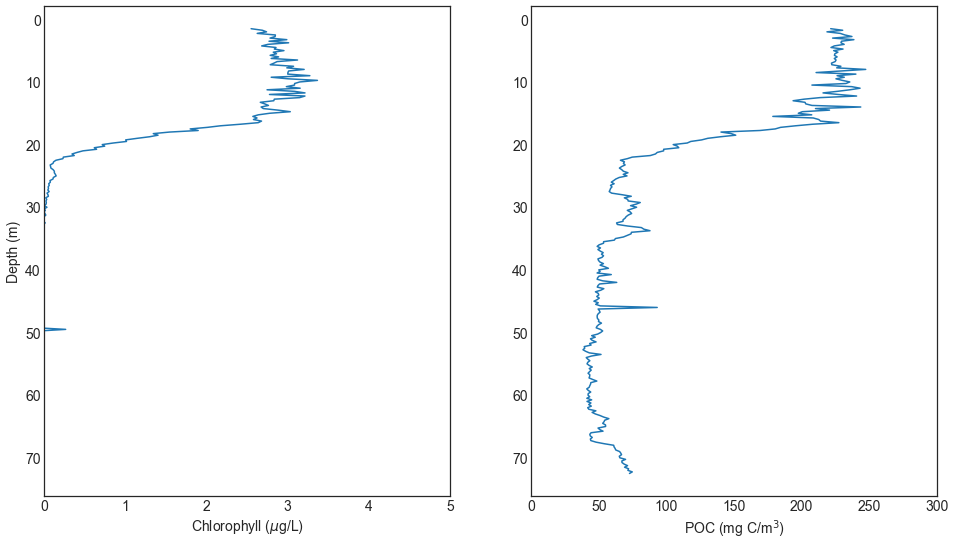

In [39]:
# plot the estimated chlorophyll and POC concentrations
plt.rcParams.update({'font.size': 14})
fig = plt.figure(figsize=(16,9))

ax1 = plt.subplot(121)
plt.plot(profile['estimated_chlorophyll'], profile['depth'])
plt.xlabel('Chlorophyll ($\mu$g/L)')
plt.ylabel('Depth (m)')
plt.xlim([0, 5])

ax2 = plt.subplot(122, sharey=ax1)
plt.plot(profile['estimated_poc'], profile['depth'])
plt.gca().invert_yaxis()
plt.xlabel('POC (mg C/m$^3$)')
plt.xlim([0, 300])
plt.show()

Finally, examining the shape and magnitudes of the absorption and attenuation spectra can be helpful in assessing the instrument performance in addition to revealing interesting information about the in situ absorption and attenuation properties of the seawater.

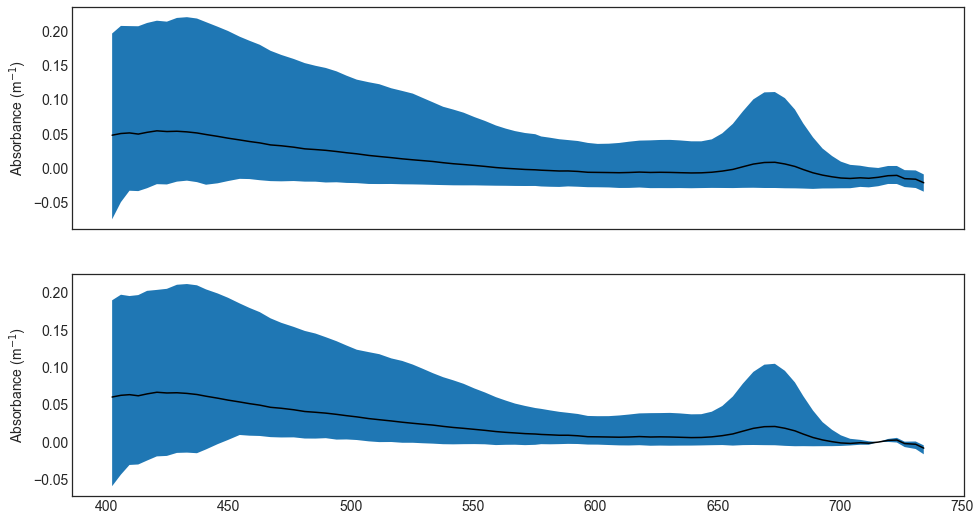

In [40]:
# plot the optical absortion spectra (as calculated by OOI and as recalculated here)
plt.rcParams.update({'font.size': 14})
fig = plt.figure(figsize=(16,9))

ax1 = plt.subplot(211)
plt.plot(profile['wavelength_a'][0, :], profile['optical_absorption'].mean(axis=0), '-k', label='profile 22')
plt.fill_between(profile['wavelength_a'][0, :], profile['optical_absorption'].min(axis=0), 
                 profile['optical_absorption'].max(axis=0))
plt.ylabel('Absorbance (m$^{-1}$)')
plt.setp(ax1.get_xticklabels(), visible=False) # turn off x-axis ticklabels

ax2 = plt.subplot(212, sharex=ax1)
plt.plot(profile['wavelength_a'][0, :], profile['apd_ts_s'].mean(axis=0), '-k', label='profile 22')
plt.fill_between(profile['wavelength_a'][0, :], profile['apd_ts_s'].min(axis=0), 
                 profile['apd_ts_s'].max(axis=0))
plt.ylabel('Absorbance (m$^{-1}$)')
plt.show()

Based on the plot of the chlorophyll and the absorbance spectra, things aren't quite right. Unfortunately, that means we are going to need to dig into the in-house pure water calibrations to see if those can be used to correct the data. It should be noted, that is a big if.....to be continued....